# Profiling tiling of titiler-pgstac and titiler-xarray

This notebook profiles code for tiling CMIP6 data via 2 methods:

1. pgSTAC + COGs: The first method uses a (local or remote) pgSTAC database for storing metadata about COGs on S3. The libraries used are pgstac for reading STAC metadata and rio_tiler's rasterio for reading COGs on S3.
2. kerchunk + netCDF: The second method uses a (local or S3) kerchunk reference file for NetCDF files stored on S3. The libraries used are xarray for reading the Zarr metadata and rio_tiler's XarrayReader for reading data from the NetCDFs on S3.

In the future, the following improvements and additions to this profiling code will be made:

1. Test with a Zarr store. The profiling code will be run on a Zarr store to compare the performance of reading from a Zarr store vs. reading from a NetCDF via kerchunk.
2. Test different chunking strategies: The profiling code will be run on a few different Zarr stores with different chunking schemes.
3. Test a higher resolution dataset.

## Setup / Step 0

1. Load some basic libraries
2. Set an initial tile to test
3. Add some AWS credentials
4. Install any missing libraries

In [1]:
import boto3
import io
from PIL import Image
import os
import warnings
import cmip6_zarr.eodc_hub_role
from matplotlib.pyplot import imshow
warnings.filterwarnings('ignore')

In [ ]:
#%%capture
#!pip install -r requirements.txt

In [2]:
xyz_tile = (0,0,0)

In [3]:
#parameters
temporal_resolution = "daily"
model = "GISS-E2-1-G"
variable = "tas"
anon=True

## Profile titiler-pgstac

To achieve the best performance, we set some GDAL environment variables.

These variables are documented here https://developmentseed.org/titiler/advanced/performance_tuning/, but that advice is copied into comments below for ease of reference.

In [4]:
# By default GDAL reads the first 16KB of the file, then if that doesn't contain the entire metadata
# it makes one more request for the rest of the metadata.
# In environments where latency is relatively high, AWS S3,
# it may be beneficial to increase this value depending on the data you expect to read.
os.environ['GDAL_INGESTED_BYTES_AT_OPEN'] = '32768'

# It's much better to set EMPTY_DIR because this prevents GDAL from making a LIST request.
# LIST requests are made for sidecar files, which does not apply for COGs
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'

# Tells GDAL to merge consecutive range GET requests.
os.environ['GDAL_HTTP_MERGE_CONSECUTIVE_RANGES'] = 'YES'

# When set to YES, this attempts to download multiple range requests in parallel, reusing the same TCP connection. 
# Note this is only possible when the server supports HTTP2, which many servers don't yet support.
# There's no downside to setting YES here.
os.environ['GDAL_HTTP_MULTIPLEX'] = 'YES'
os.environ['GDAL_HTTP_VERSION'] = '2'

# Setting this to TRUE enables GDAL to use an internal caching mechanism. It's recommended (strongly).
os.environ['VSI_CACHE'] = 'TRUE'

In [ ]:
#!pip install rio-tiler==4.1.11
#!pip install titiler
#!pip install titiler-pgstac

In [5]:
# Uncomment this line if using a local database
# os.environ['LOCAL'] == 'True'

# useful to always reload the module while its being developed
%load_ext autoreload
%autoreload

from cmip6_zarr import eodc_hub_role
credentials = eodc_hub_role.fetch_and_set_credentials()
os.environ['AWS_ACCESS_KEY_ID'] = credentials['AccessKeyId']
os.environ['AWS_SECRET_ACCESS_KEY'] = credentials['SecretAccessKey']
os.environ['AWS_SESSION_TOKEN'] = credentials['SessionToken']
import cmip6_pgstac.profile_pgstac as profile_pgstac 
from profiler.main import cprofile_list_to_dict

Caught exception: An error occurred (InvalidPermission.Duplicate) when calling the AuthorizeSecurityGroupIngress operation: the specified rule "peer: 34.213.82.245/32, TCP, from port: 5432, to port: 5432, ALLOW" already exists
Connected to database


In [ ]:
if temporal_resolution == 'daily':
    collection = f"CMIP6_daily_{model}_{variable}"
elif temporal_resolution == 'monthly':
    collection = f"CMIP6_ensemble_monthly_median_{variable}"

query = {
  "collections": [ collection ],
  "filter": {
    "op": "t_intersects",
    "args": [
      {
        "property": "datetime"
      },
      {
        "interval": [
          "1950-04-01T00:00:00Z"           
        ]
      }
    ]
  },
  "filter-lang": "cql2-json"
}

image_and_assets, cprofile = profile_pgstac.tile(*xyz_tile, query=dict(query))
cprofile

In [ ]:
all_times = cprofile_list_to_dict(cprofile['cprofile'][1:])
total_time = list(all_times.values())[0]['tottime']
total_time

**NOTES:**

* There are 2 parts to the overall timing of generating the image - `pgstac-search` and `get_tile`.
* `get_tile` above is a list with a timing for each tif. The bulk of this time is in `CustomSTACReader#tile`. That function has a subfunction `_reader` which wraps `src_dst.tile` in `self.reader`.
* The `CustomSTACReader`'s `reader` attribute is `BaseReader` from `rio_tiler.io.base`. There is no init function for BaseReader so I don't think any time is spent initializing the reader.
* `CustomSTACReader` inherits from `MultiBaseReader` so the `#tile` function is defined in that class.
* The `MultiBaseReader#tile` function also has a `_reader` subfunction which is called for each asset.
* The code for rio_tiler's `MultiBaseReader#tile#_reader` can be thought of as a **initialize reader** step and a **tile** step. 
* The bulk of the `get_tile` time is spent in the **initialize reader** step of `MultiBaseReader#tile#_reader`. The initialization of `MultiBaseReader#reader` spends most of it's time in `rasterio.open`. I have not dug into the subcalls of `rasterio.open`
* `MultiBaseReader#tile#tile` is roughly equivalent to `rasterio.io.reader#part` and wraps the reading of the WarpedVRT, so should be the sum of the previous calls.


In [ ]:
image = image_and_assets.data_as_image()
# data_as_image() returns a numpy.ndarray in form of (col, row, band
imshow(image)

## Profile titiler-xarray

In [13]:
# useful to always reload the module while its being developed
%load_ext autoreload
%autoreload
import xarray_tile_reader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Kerchunk Reference

In [14]:
image_and_assets, cprofile = xarray_tile_reader.tile(
    f"s3://nasa-eodc-data-store/combined_CMIP6_{temporal_resolution}_{model}_{variable}_kerchunk.json",
    *xyz_tile,
    reference=True,
    anon=False,
    variable=variable,
)

In [17]:
image_and_assets[1]

{'time_to_open': 272.14,
 'dimension_and_array_preprocessing': 22.21,
 'rio.clip_box': 18.38,
 'rio.reproject': 380.05,
 'ImageData()': 0.61}

In [19]:
all_times = cprofile_list_to_dict(cprofile['cprofile'][1:5])
total_time = list(all_times.values())[0]['tottime']
total_time

0.367

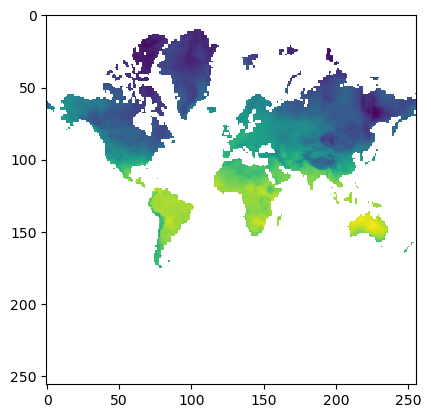

In [21]:
image = image_and_assets[0].data_as_image()
imshow(image)

## Zarr Store 1

In [22]:
image_and_assets, cprofile = xarray_tile_reader.tile(
    f"s3://nasa-eodc-data-store/CMIP6_{temporal_resolution}_{model}_{variable}.zarr",
    *xyz_tile,
    anon=False,
    variable=variable,
)

In [23]:
image_and_assets[1]

{'time_to_open': 243.38,
 'dimension_and_array_preprocessing': 11.56,
 'rio.clip_box': 18.72,
 'rio.reproject': 679.84,
 'ImageData()': 0.37}

In [24]:
all_times = cprofile_list_to_dict(cprofile['cprofile'][1:6])
total_time = list(all_times.values())[0]['tottime']
total_time

0.868

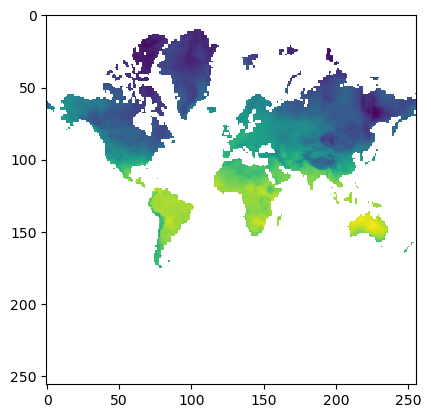

In [27]:
image = image_and_assets[0].data_as_image()
imshow(image)

# Zarr Store 2

In [28]:
image_and_assets, cprofile = xarray_tile_reader.tile(
    f"s3://nasa-eodc-data-store/600_1440_1/CMIP6_{temporal_resolution}_{model}_{variable}.zarr",
    *xyz_tile,
    anon=False,
    variable=variable,
)

In [29]:
image_and_assets[1]

{'time_to_open': 1951.65,
 'dimension_and_array_preprocessing': 13.65,
 'rio.clip_box': 18.3,
 'rio.reproject': 125.93,
 'ImageData()': 0.37}

In [30]:
all_times = cprofile_list_to_dict(cprofile['cprofile'][1:6])
total_time = list(all_times.values())[0]['tottime']
total_time

1.979

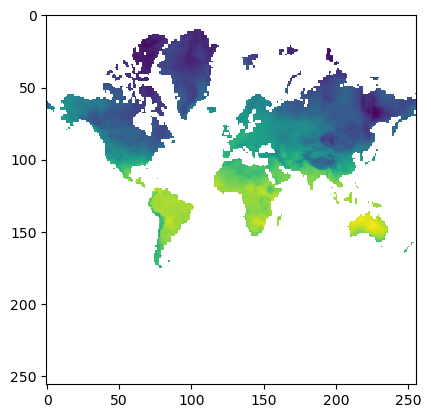

In [31]:
image = image_and_assets[0].data_as_image()
imshow(image)